In [1]:
!git clone --recursive https://github.com/bemc22/ModuloSEFL
%cd ModuloSEFL
!pip install ./deepinv/

Cloning into 'ModuloSEFL'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 144 (delta 2), reused 0 (delta 0), pack-reused 141 (from 1)
Receiving objects: 100% (144/144), 50.82 MiB | 19.10 MiB/s, done.
Resolving deltas: 100% (49/49), done.
Submodule 'deepinv' (https://github.com/deepinv/deepinv) registered for path 'deepinv'
Cloning into '/content/ModuloSEFL/deepinv'...
remote: Enumerating objects: 26321, done.        
remote: Counting objects: 100% (106/106), done.        
remote: Compressing objects: 100% (77/77), done.        
remote: Total 26321 (delta 50), reused 39 (delta 29), pack-reused 26215 (from 1)        
Receiving objects: 100% (26321/26321), 227.24 MiB | 28.72 MiB/s, done.
Resolving deltas: 100% (19703/19703), done.
Submodule path 'deepinv': checked out '891ab036ac4033c30a6b9ad71ed1c560b4355433'
/content/ModuloSEFL
Processing ./deepinv
  Installing build dependencies ... done

In [2]:
import os
import torch
import deepinv as dinv
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def normalize(x):
    x = x.clamp(min=0.0) / x.max()
    return x



size = 256
dynamic_range = 4  # dynamic range
threshold = 1.0  # threshold for spatial unwrapping
device = "cuda" if torch.cuda.is_available() else "cpu"
img_size = (size, size)
mode = "floor"  # available modes: "round", "floor"


x_rgb = np.load("example.npy")
x_rgb = torch.from_numpy(x_rgb).unsqueeze(0).to(device)
x_rgb = x_rgb.permute(0, 3, 1, 2)

x_rgb = normalize(x_rgb) * dynamic_range

In [4]:
physics = dinv.physics.SpatialUnwrapping(
    threshold=threshold, mode=mode
).to(device)


modulo_image = physics(x_rgb)

In [5]:
from models import ModuloSEFLnet

in_channels = modulo_image.shape[1]
model =  ModuloSEFLnet(mx=threshold, in_channels=in_channels, out_channels=in_channels).to(device)
model.load_state_dict(torch.load(os.path.join("ckpts", "ModuloSEFLnet_best.pth")))

<All keys matched successfully>

In [6]:
psnr_fn = dinv.loss.metric.PSNR(max_pixel=dynamic_range)
ssim_fn = dinv.loss.metric.SSIM(max_pixel=dynamic_range)

with torch.no_grad():
    x_rec = model(modulo_image)
    psnr = psnr_fn(x_rec, x_rgb).item()
    ssim = ssim_fn(x_rec, x_rgb).item()
    print(f"PSNR: {psnr:.2f} dB, SSIM: {ssim:.4f}")

PSNR: 23.33 dB, SSIM: 0.9286


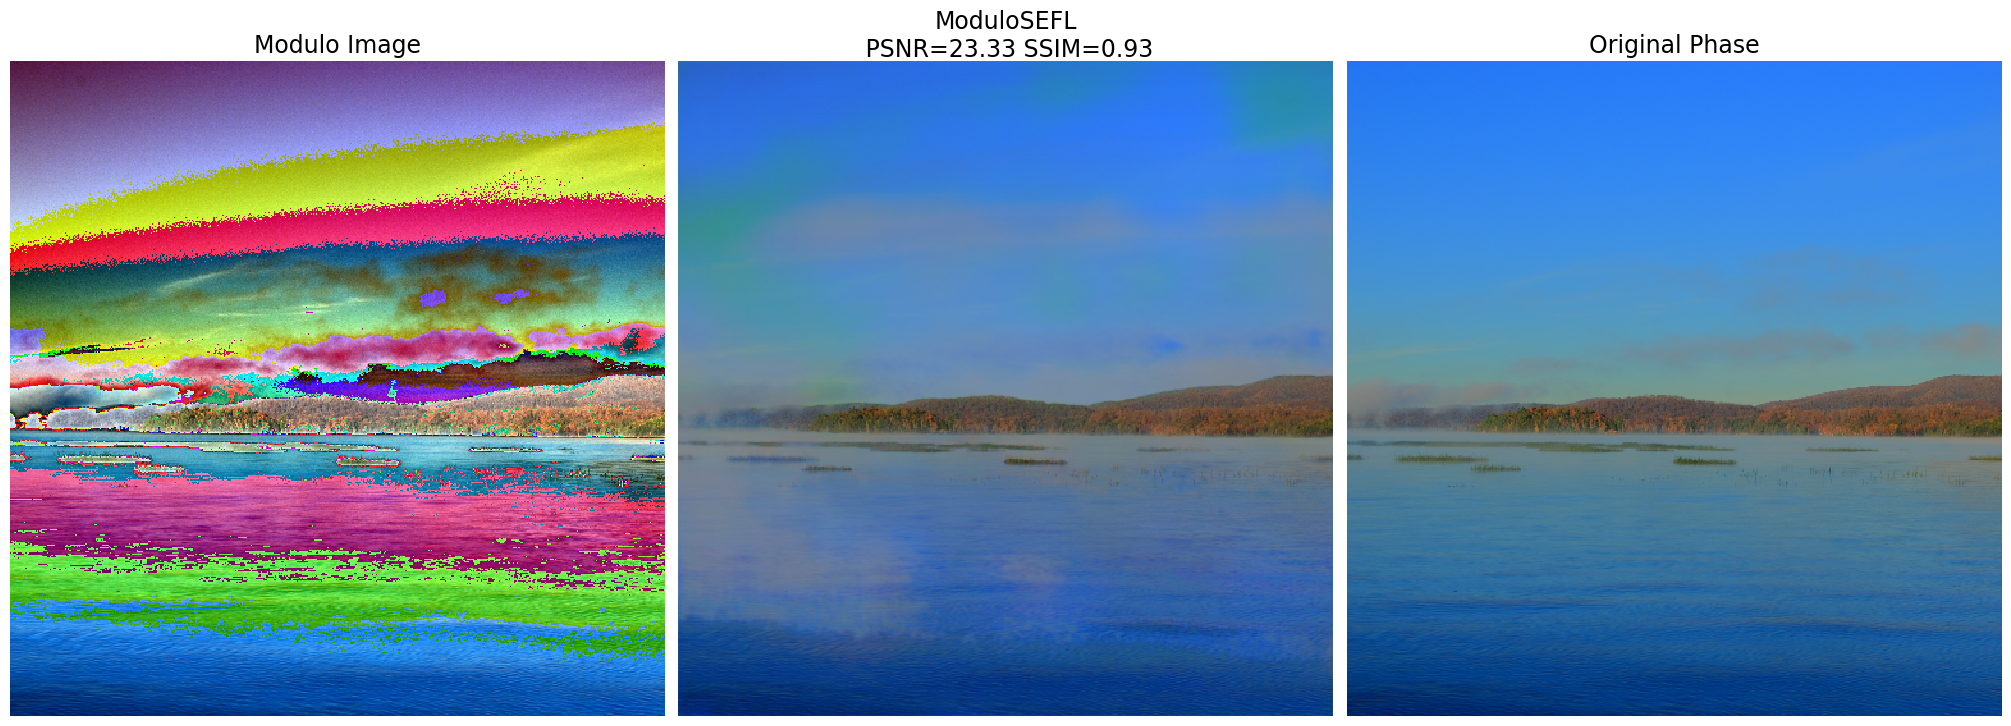

In [7]:
# Plot results
from utils import ToneMapping

tone_map = ToneMapping(factor=0.6)
x_rec_plot = tone_map(x_rec)
x_rgb_plot = tone_map(x_rgb)



imgs = [modulo_image[0],  x_rec_plot[0], x_rgb_plot[0]]
titles = [
    "Modulo Image",
    f"ModuloSEFL\n PSNR={psnr:.2f} SSIM={ssim:.2f}",
    "Original Phase",
]

dinv.utils.plotting.plot(imgs, titles=titles, cmap="gray", figsize=(20, 10))